# Setting up the environment

In [1]:
import pandas as pd
import numpy as np
import sklearn
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected = True)
import plotly.graph_objs as go
import plotly.tools as tls

import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

In [2]:
data_train = pd.read_csv('Dataset/train.csv')
data_test = pd.read_csv('Dataset/test.csv')

In [3]:
data_train.shape

(891, 12)

In [4]:
data_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [6]:
data_test.shape

(418, 11)

In [7]:
data_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [8]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


# Preprocessing the data

In [9]:
#To fill in missing values in age, we will randomize a value between (mean - std) and (mean + std)
avg_age = data_train['Age'].mean()
std_age = data_train['Age'].std()
age_null = np.random.randint(avg_age - std_age, avg_age + std_age, size = (data_train['Age'].isnull().sum()))
data_train['Age'][np.isnan(data_train['Age'])] = age_null
data_train['Age'] = data_train['Age'].astype(float)

avg_age = data_test['Age'].mean()
std_age = data_test['Age'].std()
age_null = np.random.randint(avg_age - std_age, avg_age + std_age, size = (data_test['Age'].isnull().sum()))
data_test['Age'][np.isnan(data_test['Age'])] = age_null
data_test['Age'] = data_test['Age'].astype(float)

In [10]:
#To fill in missing values in age, we will use the median
data_train['Fare'] = data_train['Fare'].fillna(data_train['Fare'].median())
data_test['Fare'] = data_test['Fare'].fillna(data_test['Fare'].median())

In [11]:
#To fill in missing values in Embarked, we will use the maximum counted category and then convert to integer
print(data_train['Embarked'].value_counts())
print(data_test['Embarked'].value_counts())
data_train['Embarked'] = data_train['Embarked'].fillna('S')
data_test['Embarked'] = data_test['Embarked'].fillna('S')
data_train['Embarked'] = data_train['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
data_test['Embarked'] = data_test['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)

S    644
C    168
Q     77
Name: Embarked, dtype: int64
S    270
C    102
Q     46
Name: Embarked, dtype: int64


In [12]:
#We will drop the name column
data_train.drop(['Name'], axis = 1, inplace = True)
data_test.drop(['Name'], axis = 1, inplace = True)

In [13]:
#We will map the sex column to 0 and 1 for female and male respectively
data_train['Sex'] = data_train['Sex'].map({'female' : 0, 'male': 1}).astype(int)
data_test['Sex'] = data_test['Sex'].map({'female' : 0, 'male': 1}).astype(int)

In [14]:
#We will drop the ticket column
data_train.drop(['Ticket'], axis = 1, inplace = True)
data_test.drop(['Ticket'], axis = 1, inplace = True)

In [15]:
#We will drop the cabin column
data_train.drop(['Cabin'], axis = 1, inplace = True)
data_test.drop(['Cabin'], axis = 1, inplace = True)

In [16]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Sex            891 non-null int32
Age            891 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Fare           891 non-null float64
Embarked       891 non-null int32
dtypes: float64(2), int32(2), int64(5)
memory usage: 55.8 KB


In [17]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 8 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Sex            418 non-null int32
Age            418 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Fare           418 non-null float64
Embarked       418 non-null int32
dtypes: float64(2), int32(2), int64(4)
memory usage: 22.9 KB


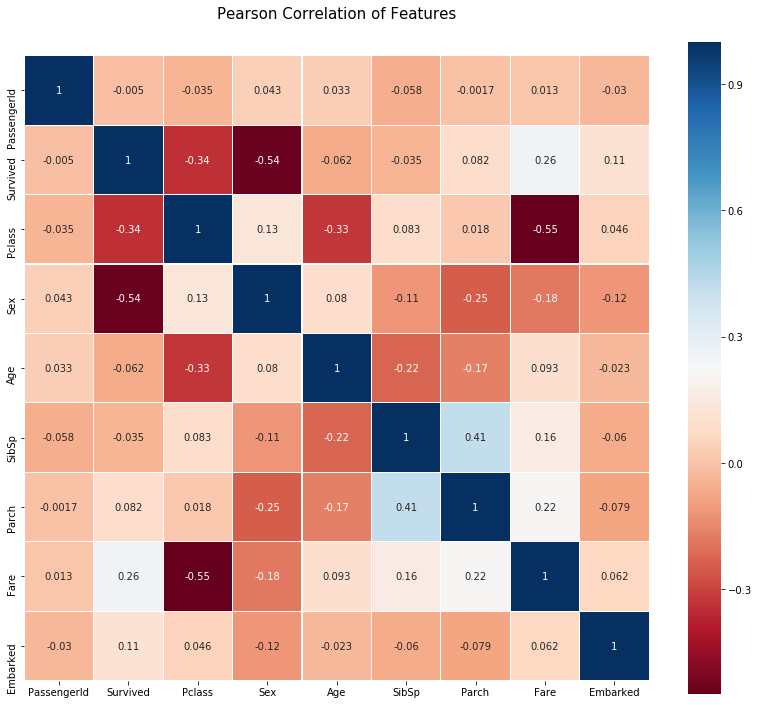

In [18]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(data_train.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

In [19]:
X_train = data_train.drop(['Survived'], axis = 1)
y_train = data_train['Survived']

In [20]:
lr_params = {
    'C': (0.0001, 0.001, 0.01, 0.1, 1, 10)
}

In [21]:
lr = LogisticRegression()

In [22]:
skf = KFold(n_splits = 5, shuffle = True, random_state = 11)

In [23]:
gcv_lr = GridSearchCV(lr, lr_params, n_jobs = -1, cv = skf, verbose = 1)
gcv_lr.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    3.8s finished


GridSearchCV(cv=KFold(n_splits=5, random_state=11, shuffle=True),
       error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'C': (0.0001, 0.001, 0.01, 0.1, 1, 10)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [24]:
lr = gcv_lr.best_estimator_

# Training and predicting

In [25]:
lr.fit(X_train, y_train)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [26]:
pred = lr.predict(data_test)

In [27]:
submission = pd.DataFrame({ 'PassengerId': data_test['PassengerId'],
                            'Survived': pred })
submission.to_csv("submissionlr.csv", index=False)